In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import project_path
from project_path import (
    module_path,
    configuration_dir, 
    data_dir, 
    report_dir,
    model_dir
)
from shorelineforecasting.utils.configs import GluonConfigs

In [2]:
tf = GluonConfigs.load_data()
tf = tf.set_index('transect_id')
tf = tf.dropna(thresh=33)
print(f"Transects included in dataset: {tf.shape[0]}; timesteps: {tf.shape[1]}")
tf.head()

Transects included in dataset: 37111; timesteps: 33


,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
transect_id,,,,,,,,,,,,,,,,,,,,,
BOX_051_151_15,677.32043,695.66370,713.29486,682.1743,688.23425,672.13007,700.43286,693.43460,699.38560,687.97950,...,700.6640,712.41740,708.45123,740.33240,680.42510,758.35150,754.49695,763.04297,743.29680,779.41570
BOX_051_151_18,768.93800,769.23883,762.44300,755.8622,761.79663,760.51710,763.30505,761.81360,769.22100,765.47060,...,763.1057,759.72600,766.23150,770.77130,798.26830,797.99615,803.90950,797.90780,798.18830,803.68256
BOX_051_151_21,711.41626,684.20540,695.49817,701.6695,705.29990,703.61470,707.69403,692.90360,704.68280,704.99945,...,825.8698,820.51720,820.68680,842.18097,850.45460,775.96700,883.04240,867.92426,877.37415,874.50244
BOX_051_151_30,795.81573,820.63700,799.72380,799.8664,823.56260,822.07300,823.56800,823.73300,824.58400,824.33360,...,823.7820,823.15674,823.65790,821.31860,818.85803,817.31220,822.92970,818.73350,822.18480,818.73480
BOX_051_151_32,242.70204,238.05159,229.93718,244.0620,247.68105,257.49900,302.69217,301.27722,301.12033,316.40414,...,301.1231,313.63553,313.09814,312.90347,306.18658,294.18326,297.23654,302.88650,323.85840,304.36823


In [3]:
sites = pd.read_csv("/media/storage/data/shorelines/sites-gluonts-prepared-37k.csv")
sites = sites.loc[sites['transect_id'].isin(tf.index)]
print(f"Transects included in dataset: {sites.shape[0]}; metadata columns: {sites.shape[1]}")
sites.head()

Transects included in dataset: 37111; metadata columns: 27


,transect_id,country_id,continent,country_name,changerate,changerate_unc,flag_sandy,no_shorelines,RMSE,Timespan,...,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,coastline_idint,geometry,dbscan_cluster,fcluster,optics_clusters
0,BOX_051_170_3,ARG,South America,Argentina,0.389332,0.344834,True,33.0,18.281954,32.0,...,-36.378387,-56.709120,-36.376892,-56.700333,-36.375397,7427,POINT (-56.70912170410156 -36.37689208984375),0,2455,0
1,BOX_051_170_4,ARG,South America,Argentina,0.501007,0.390176,True,33.0,20.685827,32.0,...,-36.374847,-56.710050,-36.373356,-56.701260,-36.371860,7427,POINT (-56.71004867553711 -36.37335586547852),0,2455,0
2,BOX_051_170_5,ARG,South America,Argentina,0.831012,0.331491,True,33.0,17.574545,32.0,...,-36.371933,-56.711193,-36.369860,-56.702587,-36.367786,7427,POINT (-56.7111930847168 -36.3698616027832),0,2455,0
3,BOX_051_170_6,ARG,South America,Argentina,1.471142,0.277497,True,33.0,14.711926,32.0,...,-36.368470,-56.712482,-36.366394,-56.703876,-36.364323,7427,POINT (-56.71248245239258 -36.36639404296875),0,2455,0
4,BOX_051_170_7,ARG,South America,Argentina,2.159336,0.288062,True,33.0,15.272047,32.0,...,-36.365000,-56.713768,-36.362930,-56.705162,-36.360855,7427,POINT (-56.71376800537109 -36.36293029785156),0,2455,0


In [4]:
rebase = lambda x: x-x[0]
tf_t = tf.apply(rebase, axis=1)

In [5]:
metadata = {
    'num_series': len(tf),
    'num_steps': len(tf.columns),
    'prediction_length': 7,
    'freq': "AS",
    'start': [pd.Timestamp("01-01-1984", freq='AS') for _ in range(len(tf))],
    'item_id': tf.index.values,
    'epochs': 10,
    'save_model': True,
    'evaluate_model': True
}

metadata['context_length'] = metadata['num_steps'] - metadata['prediction_length']

In [6]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName


def get_gluon_ds(df, sample=None):
    
    if sample is not None:
        df = df.sample(sample)

    train_ds = ListDataset(
        [
         {
             FieldName.TARGET: target,
             FieldName.START: start,
             FieldName.ITEM_ID: item_id,
             FieldName.FEAT_STATIC_CAT: [fclust, dbclust],
             FieldName.FEAT_STATIC_REAL: [fsr]
          }

         for (target, start, item_id, fclust, dbclust, fsr) in zip(df.values[:, :-metadata['prediction_length']],
                                            metadata['start'], 
                                            metadata['item_id'],
                                            sites['fcluster'].values,
                                            sites['dbscan_cluster'].values,
                                            sites['changerate_unc'].values)
        ], freq=metadata['freq'])

    test_ds = ListDataset(
        [
         {
             FieldName.TARGET: target,
             FieldName.START: start,
             FieldName.ITEM_ID: item_id,
             FieldName.FEAT_STATIC_CAT: [fclust, dbclust],
             FieldName.FEAT_STATIC_REAL: [fsr]
          }

         for (target, start, item_id, fclust, dbclust, fsr) in zip(df.values,
                                            metadata['start'], 
                                            metadata['item_id'],
                                            sites['fcluster'].values,
                                            sites['dbscan_cluster'].values,
                                            sites['changerate_unc'].values)
        ], freq=metadata['freq'])
          
    return train_ds, test_ds

In [7]:
train_ds, test_ds = get_gluon_ds(tf_t, sample=1000)

In [8]:
from sklearn import preprocessing

from shorelineforecasting.models.helpers import (
    to_dataframe,
    configure_torch,
    get_lstm_configs,
    get_scaled_splits,
    evaluate_performance,
    to_torch_dataloaders
)


In [9]:
lstm_configs ={
    "batch_size": 10,
    "train_window": len(tf_t.columns)-metadata['prediction_length'],
    "input_size": 1,
    "epochs": 10,
    "learning_rate": 0.01,
    "horizon": 7   
}

In [10]:
train, val, test, test_raw, test_scaler = get_scaled_splits(tf_t, ratio=.8)
dataloaders = to_torch_dataloaders(train, val, test, prediction_length=metadata['prediction_length'],
                                    batch_size=10)



Dataloader: train shape: torch.Size([10, 26]), target shape: torch.Size([10, 7])


In [11]:
print(len(train))
print(len(val))
print(len(test))

23750
5938
7423


In [12]:
import torch
import torch.nn as nn


class SimpleLSTM(nn.Module):
    """
    Simple RNN (LSTM) network.
    """

    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.out = nn.Sequential(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)
        out = self.out(r_out[:, -1, :])
        return out
    
rnn = SimpleLSTM(input_size=1, hidden_size=64, output_size=metadata['prediction_length'])
print(rnn)

SimpleLSTM(
  (rnn): LSTM(1, 64, batch_first=True)
  (out): Sequential(
    (0): Linear(in_features=64, out_features=7, bias=True)
  )
)


In [13]:
from shorelineforecasting.models.lstm import (
    
    train_model,
    inference_model
)

# train_model(rnn, dataloaders, lstm_configs)

In [14]:
lstm_configs['horizon'] = 1
lstm_configs['forecast_size'] = lstm_configs['train_window'] + metadata['prediction_length'] * lstm_configs['horizon']
lstm_configs['evaluation'] = ["mse", "mase", "mape", "smape", "rmse", "nrmse"]
lstm_configs['output_size'] = metadata['prediction_length']

# forecast = inference_model(rnn, dataloaders['test'], lstm_configs)

In [16]:
def to_dataframe(forecast_tensor, model_configs, target, inverse_scaling=True, test_scaler=None, transpose=False):
    df = pd.DataFrame(forecast_tensor.numpy()[:, :, 0])
    if inverse_scaling is True:
        df = pd.DataFrame(test_scaler.inverse_transform(df))
    df.index = target.index[:len(df)]
    df.columns = pd.RangeIndex(start=1984, stop=1984+model_configs['forecast_size'], step=1)
    return df

# forecast = to_dataframe(forecast, lstm_configs, test, inverse_scaling=True, test_scaler=test_scaler)


In [30]:
from shorelineforecasting.utils.forecasting_metrics import evaluate_

def evaluate_performance(target, forecast, metrics):
    tw = lstm_configs['train_window']
    pl = metadata['prediction_length']
       
    actual = target[tw:tw + pl]
    forecast_ = forecast[tw: tw + pl]
    
    metrics = evaluate_(
        time_series=target,
        predicted=forecast_,
        metrics=metrics
    )
    return list(metrics.values())

### Cross validation

In [37]:
lstm_configs ={
    "batch_size": 10,
    "train_window": len(tf_t.columns)-metadata['prediction_length'],
    "input_size": 1,
    "epochs": 10,
    "learning_rate": 0.01,
    "horizon": 1   
}

lstm_configs['horizon'] = 1
lstm_configs['forecast_size'] = lstm_configs['train_window'] + metadata['prediction_length'] * lstm_configs['horizon']
lstm_configs['evaluation'] = ["MSE", "abs_error", "abs_target_sum", "abs_target_mean", "seasonal_error", "MASE", "MAPE", "sMAPE"]
lstm_configs['output_size'] = metadata['prediction_length']

cross_validation = 5
results = []
for i in range(cross_validation):
    
    train, val, test, test_raw, test_scaler = get_scaled_splits(
        timeframe=tf_t,
        ratio=.8
    )

    dataloaders = to_torch_dataloaders(
        train_ds=train, 
        validation_ds=val, 
        test_ds=test, 
        prediction_length=metadata['prediction_length'],
        batch_size=10
    )
    
    rnn = SimpleLSTM(
        input_size=1, 
        hidden_size=64, 
        output_size=metadata['prediction_length']
    )

    train_model(rnn, dataloaders, lstm_configs)
    
    forecast = inference_model(
        model=rnn,
        dataloader=dataloaders['test'],
        model_configs=lstm_configs
    )
    
    forecast = to_dataframe(
        forecast_tensor=forecast,
        model_configs=lstm_configs, 
        target=test,
        inverse_scaling=True, 
        test_scaler=test_scaler
    )
    
    eval_metrics = forecast.apply(
        lambda x: evaluate_performance(
            test_raw.loc[x.name].values, x.values, lstm_configs["evaluation"]
        ), axis=1, result_type="expand"
    )
    
    eval_metrics.columns = lstm_configs['evaluation']
    eval_metrics = eval_metrics.reset_index()
    eval_metrics['cv'] = i
    
    results.append(eval_metrics)

Dataloader: train shape: torch.Size([10, 26]), target shape: torch.Size([10, 7])
Epoch 1 Train Loss:2.325610536133751, Val Loss:0.32450808334575704
Epoch 2 Train Loss:2.0315091850230695, Val Loss:0.6952910720884196
Epoch 3 Train Loss:1.8979639810433737, Val Loss:0.35914550456360084
Epoch 4 Train Loss:1.8438742171512326, Val Loss:0.36998008433964946
Epoch 5 Train Loss:1.808786664326056, Val Loss:0.39990697561324595
Epoch 6 Train Loss:1.7932338703397417, Val Loss:0.3714028963544255
Epoch 7 Train Loss:1.7876584741157726, Val Loss:0.37499171856215957
Epoch 8 Train Loss:1.7770254501115983, Val Loss:0.5554623982288043
Epoch 9 Train Loss:1.7728098958588536, Val Loss:0.3252142456127597
Epoch 10 Train Loss:1.7551464029224328, Val Loss:0.32942256252722335
Finish training
Dataloader: train shape: torch.Size([10, 26]), target shape: torch.Size([10, 7])
Epoch 1 Train Loss:2.1724193788667367, Val Loss:0.5177745475704848
Epoch 2 Train Loss:1.8567989549379444, Val Loss:0.43379828087712563
Epoch 3 Trai

In [39]:
o = pd.concat(results)

In [62]:
from shorelineforecasting.utils.configs import get_predictor_id

predictor_id = get_predictor_id()

o['predictor'] = 'SimpleLSTM'
o['predictor_id'] = predictor_id
o = o.rename(columns={'transect_id':'item_id'})
o = o.drop(columns='cv')

In [49]:
d = pd.concat(results)
d.columns = ['item_id', 'MSE', 'MASE', 'MAPE', 'sMAPE', 'RMSE', 'NRMSE', 'MAE', 'cv-id']
d['predictor'] = 'SimpleLSTM'
d['predictor_id'] = 469
d.loc[d['mase']!=np.inf].mean()

18.15556347656285

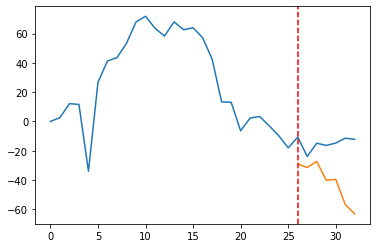

In [82]:
fig, ax = plt.subplots()
idx_label = forecast.iloc[0].index
transect = forecast.iloc[0].name
ax.plot(range(len(forecast.iloc[0])), forecast.iloc[0].values)
ax.plot(range(len(test_raw.loc[transect]))[-7:], test_raw.loc[transect][-7:])
ax.axvline(x=range(len(test_raw.loc[transect]))[-7], color='red', linestyle='--')

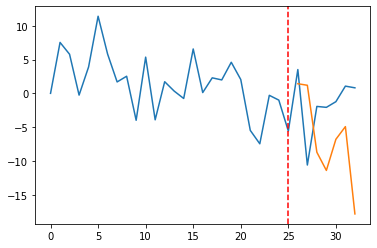

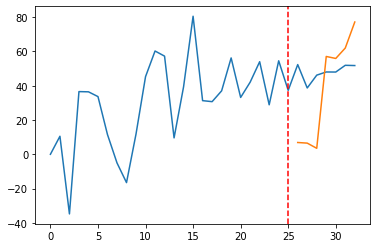

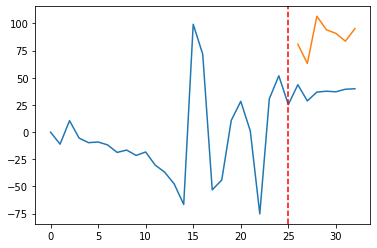

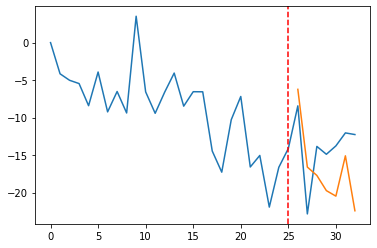

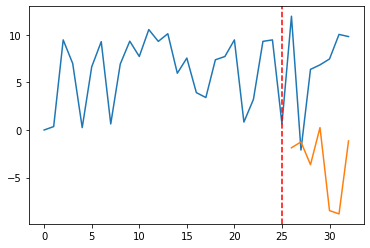

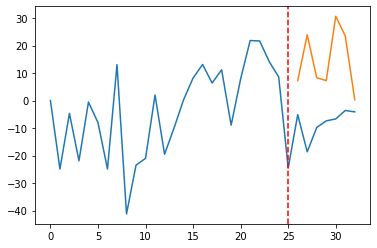

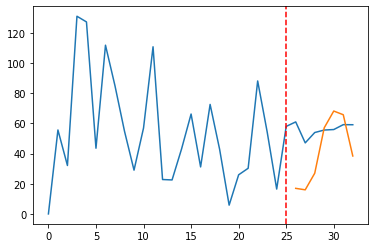

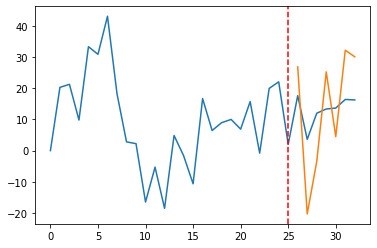

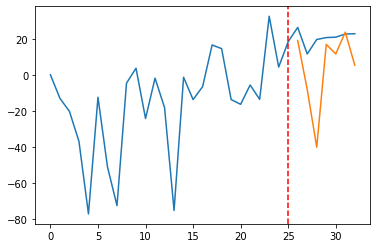

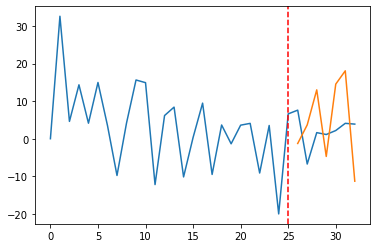

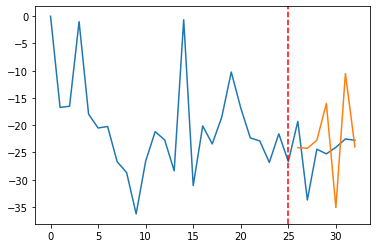

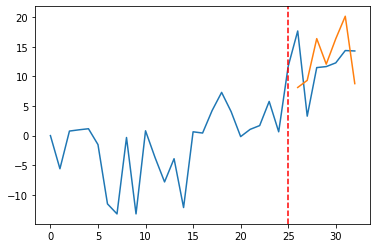

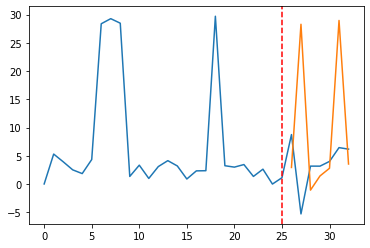

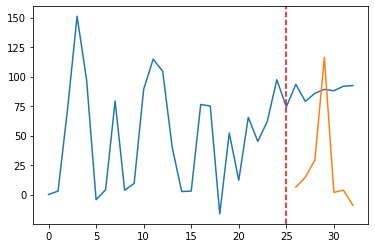

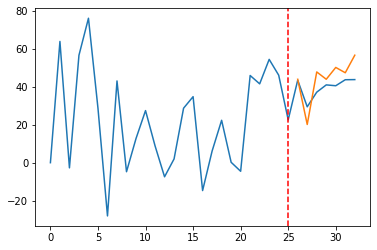

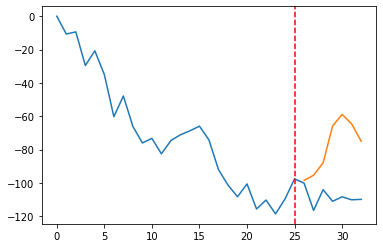

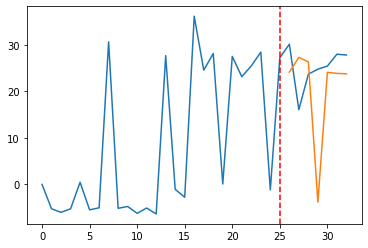

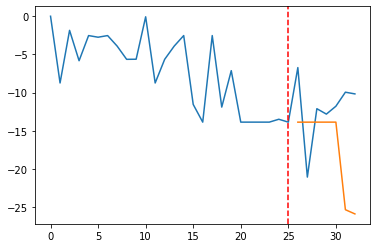

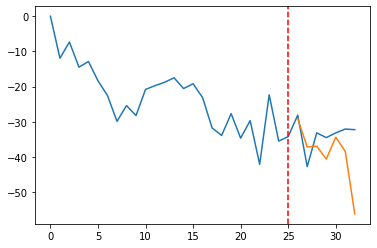

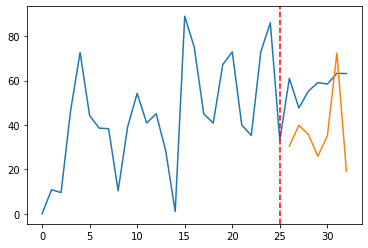

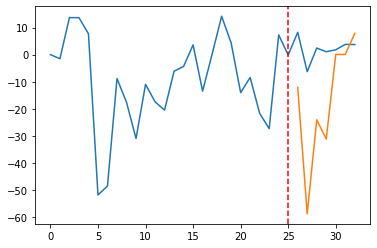

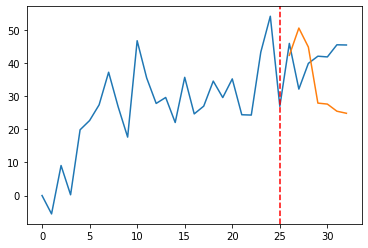

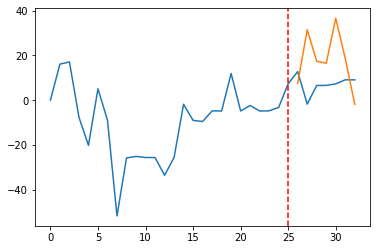

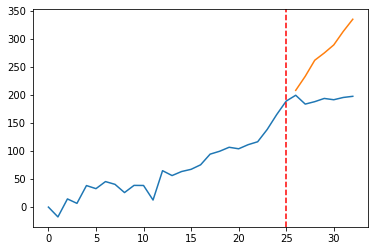

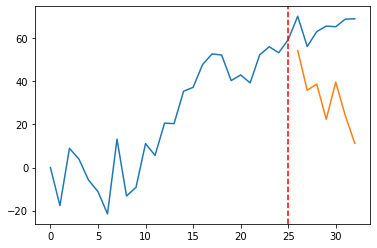

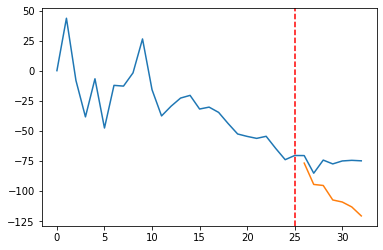

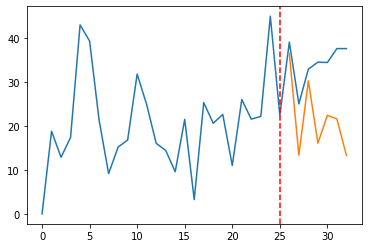

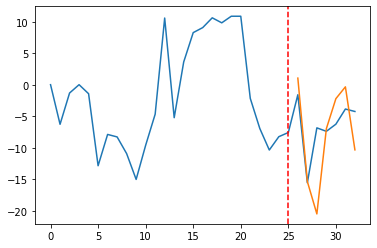

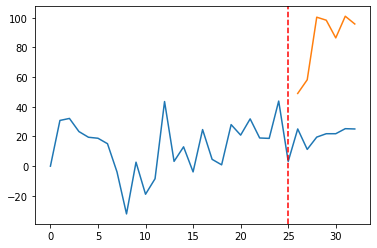

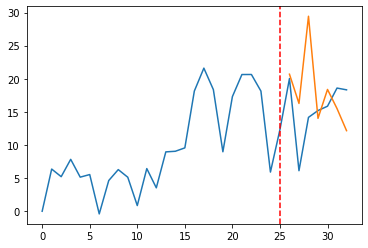

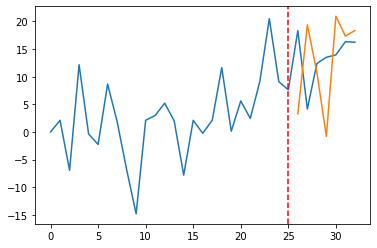

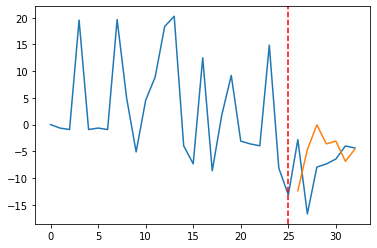

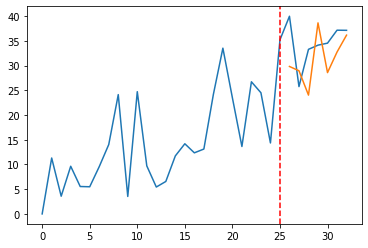

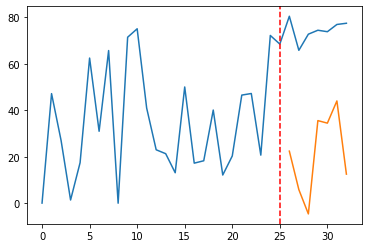

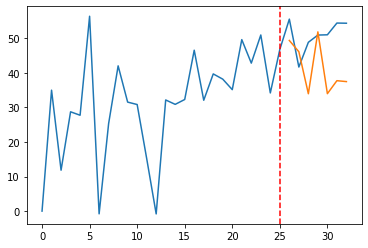

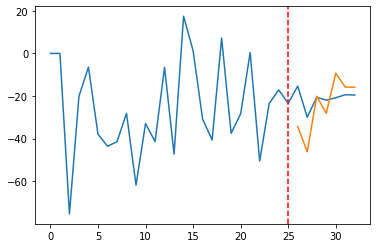

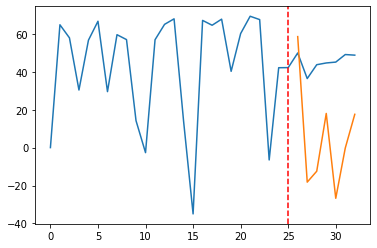

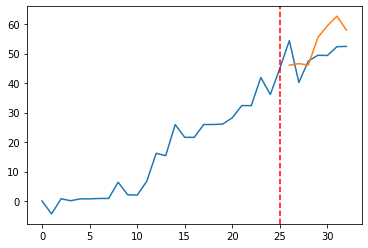

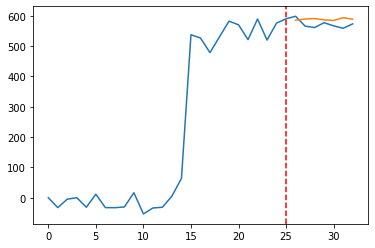

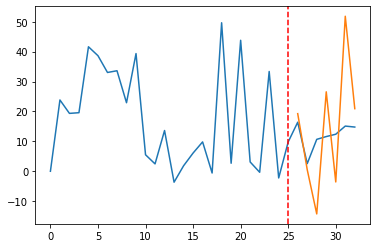

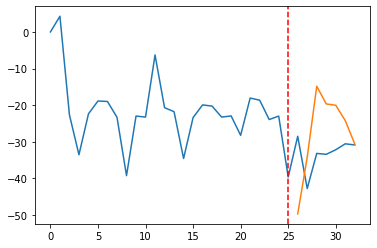

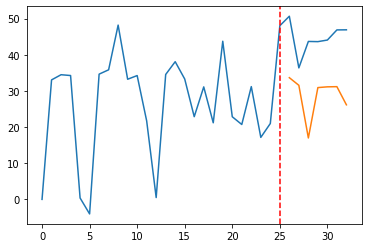

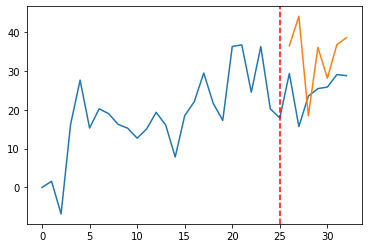

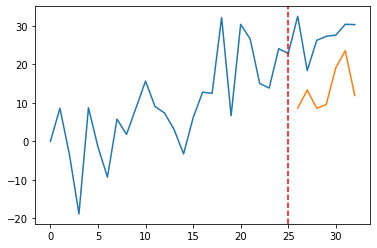

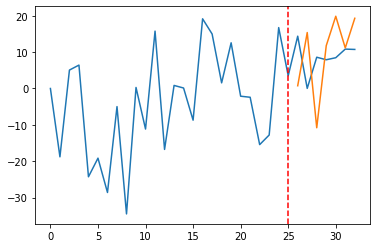

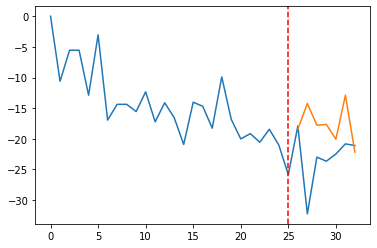

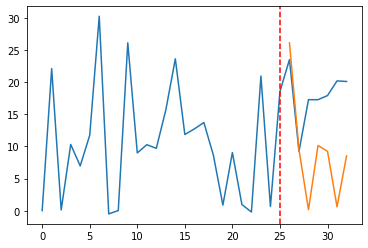

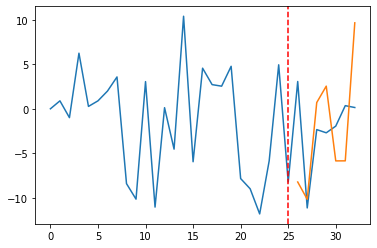

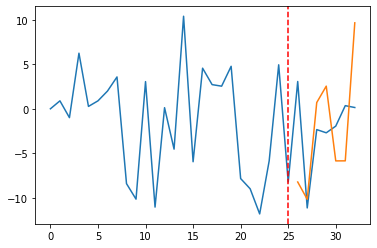

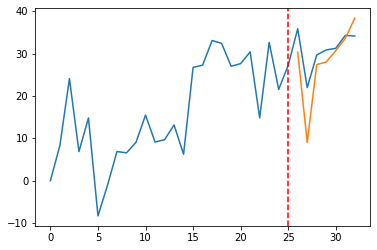

In [84]:
indices = np.random.choice(np.arange(0, len(forecast), 1), size=50)
for idx in indices:
#     forecast.iloc[idx].plot()
#     plt.plot(test_raw.loc[forecast.iloc[idx].name])
#     test_raw.loc[forecast.iloc[idx].name].plot()

    fig, ax = plt.subplots()
    idx_label = forecast.iloc[idx].index
    transect = forecast.iloc[idx].name

    ax.plot(range(len(forecast.iloc[idx])), forecast.iloc[idx].values)
    ax.plot(range(len(test_raw.loc[transect]))[-7:], test_raw.loc[transect][-7:])
    ax.axvline(x=range(len(test_raw.loc[transect]))[-8], color='red', linestyle='--')
    
    plt.show()